In [2]:
#Importing Necessary Libraries
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, GlobalAveragePooling2D,
                                     Dense, Dropout, BatchNormalization, Flatten, Activation) 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import shutil


**Forming new folder to store the splitted data**

In [3]:
# --- 1. Data Setup and Splitting ---
print("--- Setting up Directories ---")
source_data_dir = '/kaggle/input/training-sample-all/training_samples_all' # Source directory
output_base_dir = './asl_split_dataset_v2' # Use a new directory for the split
train_output_dir = os.path.join(output_base_dir, 'train')
val_output_dir = os.path.join(output_base_dir, 'validation') # Create validation directory
test_output_dir = os.path.join(output_base_dir, 'test')

# Clean up previous split if it exists
if os.path.exists(output_base_dir):
    print(f"Removing existing directory: {output_base_dir}")
    shutil.rmtree(output_base_dir)

for directory in [output_base_dir, train_output_dir, val_output_dir, test_output_dir]:
    os.makedirs(directory)
    print(f"Created directory: {directory}")

# Check dataset structure
print("\n--- Checking Source Dataset ---")
if os.path.exists(source_data_dir):
    print(f"Source directory '{source_data_dir}' exists.")
    try:
        print(f"Listing first 5 items in source: {os.listdir(source_data_dir)[:5]}")
    except Exception as e:
        print(f"Could not list directory contents: {e}")
else:
    print(f"ERROR: Source directory '{source_data_dir}' not found! Please check the path.")
    # Exit or handle error appropriately if the source doesn't exist
    exit()


def split_and_organize_dataset_3way(source_dir, train_dir, val_dir, test_dir,
                                     train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split the dataset into training, validation, and test sets.
    """
    print(f"\n--- Starting Dataset Split (Train: {train_ratio}, Val: {val_ratio}, Test: {test_ratio}) ---")
    # Check that ratios sum to 1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "Ratios must sum to 1"

    if not os.path.exists(source_dir):
        print(f"ERROR: Source directory '{source_dir}' not found during split.")
        return

    # Get class folders
    try:
        class_folders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]
        if not class_folders:
             print(f"ERROR: No class folders found in '{source_dir}'. Check dataset structure.")
             return
        print(f"Found {len(class_folders)} classes: {class_folders[:5]}...") # Print first 5
    except Exception as e:
        print(f"ERROR listing class folders in '{source_dir}': {e}")
        return


    total_train, total_val, total_test = 0, 0, 0

    for class_folder in class_folders:
        source_class_dir = os.path.join(source_dir, class_folder)
        train_class_dir = os.path.join(train_dir, class_folder)
        val_class_dir = os.path.join(val_dir, class_folder)
        test_class_dir = os.path.join(test_dir, class_folder)

        for dir_path in [train_class_dir, val_class_dir, test_class_dir]:
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)

        try:
            image_files = [f for f in os.listdir(source_class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if not image_files:
                print(f"Warning: No images found in class folder '{source_class_dir}'")
                continue # Skip this class if empty

            random.shuffle(image_files)

            n_images = len(image_files)
            n_train = int(train_ratio * n_images)
            n_val = int(val_ratio * n_images)
            # n_test is the remainder

            train_files = image_files[:n_train]
            val_files = image_files[n_train : n_train + n_val]
            test_files = image_files[n_train + n_val :]

            # Copy files
            for files, dest_dir in zip([train_files, val_files, test_files],
                                    [train_class_dir, val_class_dir, test_class_dir]):
                for file in files:
                    src_path = os.path.join(source_class_dir, file)
                    dst_path = os.path.join(dest_dir, file)
                    try:
                        shutil.copy2(src_path, dst_path)
                    except Exception as copy_e:
                        print(f"ERROR copying {src_path} to {dst_path}: {copy_e}")


            print(f"Class '{class_folder}': {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
            total_train += len(train_files)
            total_val += len(val_files)
            total_test += len(test_files)

        except Exception as class_e:
             print(f"ERROR processing class folder '{source_class_dir}': {class_e}")


    print("\n--- Split Summary ---")
    print(f"Total training images: {total_train}")
    print(f"Total validation images: {total_val}")
    print(f"Total test images: {total_test}")
    print("----------------------")


# Split and organize dataset (using 70% Train, 15% Validation, 15% Test)
split_and_organize_dataset_3way(source_data_dir, train_output_dir, val_output_dir, test_output_dir,
                                train_ratio=0.7, val_ratio=0.15, test_ratio=0.15)


--- Setting up Directories ---
Created directory: ./asl_split_dataset_v2
Created directory: ./asl_split_dataset_v2/train
Created directory: ./asl_split_dataset_v2/validation
Created directory: ./asl_split_dataset_v2/test

--- Checking Source Dataset ---
Source directory '/kaggle/input/training-sample-all/training_samples_all' exists.
Listing first 5 items in source: ['N', 'R', 'B', 'I', 'F']

--- Starting Dataset Split (Train: 0.7, Val: 0.15, Test: 0.15) ---
Found 25 classes: ['N', 'R', 'B', 'I', 'F']...
Class 'N': 979 train, 210 val, 211 test
Class 'R': 979 train, 210 val, 211 test
Class 'B': 979 train, 210 val, 211 test
Class 'I': 979 train, 210 val, 211 test
Class 'F': 979 train, 210 val, 211 test
Class 'H': 979 train, 210 val, 211 test
Class 'E': 979 train, 210 val, 211 test
Class 'U': 982 train, 210 val, 211 test
Class 'M': 979 train, 210 val, 211 test
Class 'X': 979 train, 210 val, 211 test
Class 'K': 979 train, 210 val, 211 test
Class 'Q': 975 train, 208 val, 210 test
Class 'Y':

 **Conversion of Gray Image to RGB**

In [4]:
def add_color_jitter_and_noise(img):
  
    # Color jitter (brightness/contrast)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[..., 2] = hsv[..., 2] * np.random.uniform(0.9, 1.1)  # brightness
    hsv[..., 1] = hsv[..., 1] * np.random.uniform(0.9, 1.1)  # saturation
    hsv = np.clip(hsv, 0, 255)
    img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # Gaussian noise
    noise = np.random.normal(0, 10, img.shape)
    img = img + noise
    img = np.clip(img, 0, 255)

    return img


In [5]:
#ImageGeneration
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    preprocessing_function=add_color_jitter_and_noise,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [6]:
train_dir='/kaggle/working/asl_split_dataset_v2/train'
val_dir='/kaggle/working/asl_split_dataset_v2/validation'

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 24474 images belonging to 25 classes.
Found 5248 images belonging to 25 classes.


Class Distribution:
A: 979
B: 979
C: 979
D: 979
E: 979
F: 979
G: 979
H: 979
I: 979
J: 979
K: 979
L: 979
M: 979
N: 979
O: 979
P: 979
Q: 975
R: 979
S: 979
T: 979
U: 982
V: 979
W: 979
X: 979
Y: 979


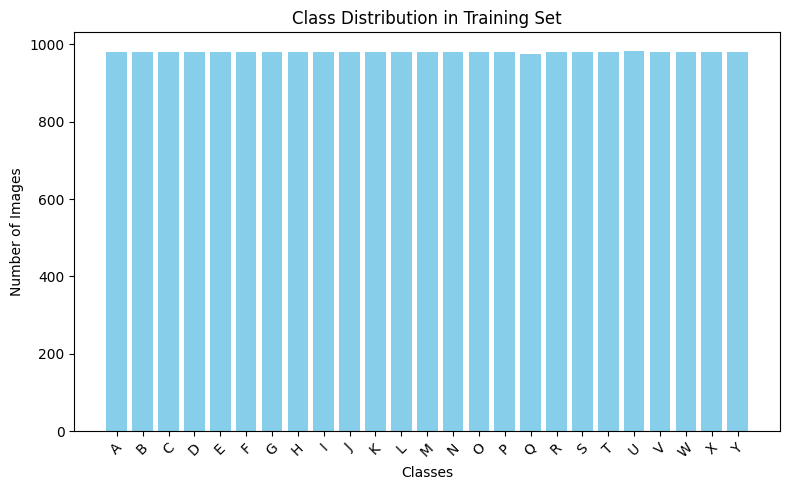

In [8]:

class_indices = train_generator.class_indices
classes = list(class_indices.keys())

labels = train_generator.classes
unique, counts = np.unique(labels, return_counts=True)

class_counts = dict(zip(classes, counts))


print("Class Distribution:")
for label, count in class_counts.items():
    print(f"{label}: {count}")

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
nb_classes = 25


model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(128, 128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.005))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.05))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.05))

model.add(Dense(nb_classes, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745736219.700764      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745736219.701592      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 11,698,073 (44.62 MB)

 Trainable params: 11,694,105 (44.61 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [12]:
epochs = 70 


from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


checkpoint = ModelCheckpoint("model_weights_best_loss.keras",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2, 
                              patience=3, 
                              verbose=1,
                              min_lr=1e-6) 

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10, 
                           verbose=1,
                           restore_best_weights=True) 

callbacks_list = [checkpoint, reduce_lr, early_stop]


history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks_list,
)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745736232.006958     111 service.cc:148] XLA service 0x7f92b4002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745736232.007930     111 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745736232.007954     111 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745736232.782806     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/383 ━━━━━━━━━━━━━━━━━━━━ 2:58:35 28s/step - accuracy: 0.0938 - loss: 3.3909

I0000 00:00:1745736250.362882     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.6952 - loss: 1.1808
Epoch 1: val_loss improved from inf to 2.16508, saving model to model_weights_best_loss.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 184s 407ms/step - accuracy: 0.6957 - loss: 1.1793 - val_accuracy: 0.3975 - val_loss: 2.1651 - learning_rate: 1.0000e-04
Epoch 2/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9741 - loss: 0.1323
Epoch 2: val_loss improved from 2.16508 to 0.17803, saving model to model_weights_best_loss.keras
383/383 ━━━━━━━━━━━━━━━━━━━━ 144s 367ms/step - accuracy: 0.9741 - loss: 0.1323 - val_accuracy: 0.9411 - val_loss: 0.1780 - learning_rate: 1.0000e-04
Epoch 3/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9860 - loss: 0.0702
Epoch 3: val_loss did not improve from 0.17803
383/383 ━━━━━━━━━━━━━━━━━━━━ 143s 365ms/step - accuracy: 0.9860 - loss: 0.0702 - val_accuracy: 0.9339 - val_loss: 0.2188 - learning_rate: 1.0000e-04
Epoch 4/70
383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accur

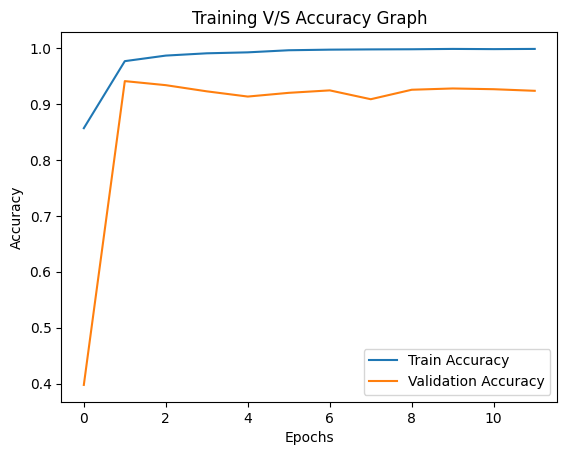

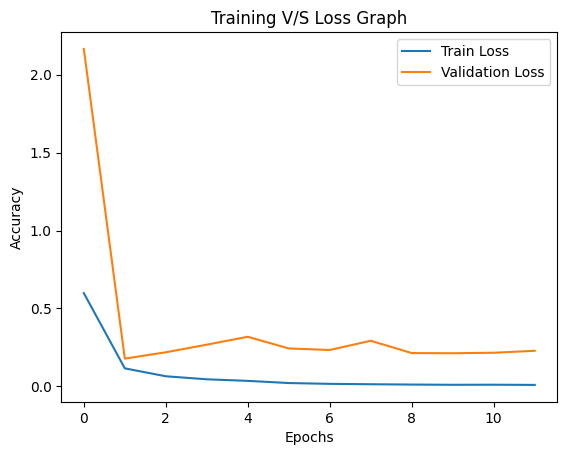

In [13]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training V/S Accuracy Graph")
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training V/S Loss Graph")
plt.legend()
plt.show()

In [14]:

class_names = list(val_generator.class_indices.keys())


y_true = val_generator.classes


Y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step


/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [15]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

           A       0.98      0.96      0.97       210
           B       1.00      0.79      0.88       210
           C       1.00      0.98      0.99       210
           D       0.99      0.97      0.98       210
           E       1.00      0.88      0.94       210
           F       1.00      1.00      1.00       210
           G       1.00      0.95      0.98       210
           H       0.98      1.00      0.99       210
           I       1.00      0.98      0.99       210
           J       0.98      1.00      0.99       210
           K       1.00      0.97      0.98       210
           L       1.00      1.00      1.00       210
           M       0.89      0.76      0.82       210
           N       0.50      0.99      0.67       210
           O       1.00      0.98      0.99       210
           P       0.96      1.00      0.98       210
           Q       1.00      1.00      1.00       208
   

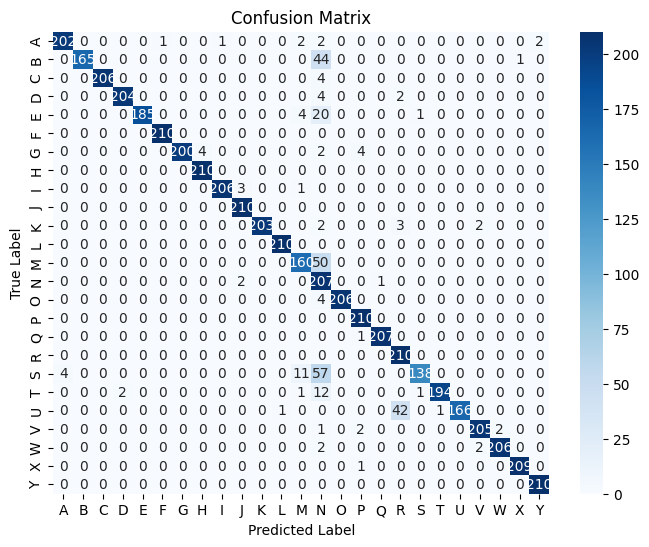

In [16]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
